# Hate Speech Classification

### Import all necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, LSTM, Embedding,Dropout,SpatialDropout1D,Conv1D,MaxPooling1D,GRU,BatchNormalization
from tensorflow.keras.layers import Input,Bidirectional,GlobalAveragePooling1D,GlobalMaxPooling1D,concatenate,LeakyReLU
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
import keras


In [2]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9259045533086274731
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3667263488
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12353262429903013472
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


### Load the dataset

In [9]:
import tensorflow as tf

with tf.device("gpu:0"):
   print("tf.keras code in this scope will run on GPU")

tf.keras code in this scope will run on GPU


In [3]:
tweets = pd.read_csv("train.csv")

## Cleaning the dataset
#### Remove URLs, abbrevations, email, signs 
#### Stop words removal
#### Stemming - Porter Stemmer is used
#### Lemmatixation - Wornet Lemmatizer
#### Removing other non alphabetic character

In [4]:
stop_words = stopwords.words('english')
stop_words.extend(["br"]) # Added the line break tag br to the stop words as it is not necessary
stop_words = set(stop_words)

lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def lemmatize(word):
    return lemmatizer.lemmatize(word)

def clean_text(text):
    text = text.lower().split()
    
    stops = stop_words
    text = [w for w in text if not w in stops and len(w) >= 3]
    text = " ".join(text)
    
    text = re. sub(r'https?://[A-Za-z0-9./]+', 'url', text)
    text = re. sub(r"[^A-Za-z0-g^,!.V'+-=]"," ", text)
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"\'s", " ", text)
    text = re. sub(r"\'ve", "have", text)
    text = re.sub(r"n't", "not", text)
    text = re.sub(r"i'm", "i am", text)
    text = re. sub(r"\'re", "are", text)
    text = re.sub(r"\'d", "would", text)
    text = re.sub(r"\'ll", "will", text)
    text = re.sub(r",", " ",text)
    text = re.sub(r"\.", " ",text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re. sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + " , text)
    text = re.sub(r"\-", " - " , text)
    text = re.sub(r"\=", " = " , text)
    text = re. sub(r"'", " " , text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re. sub(r":", " : ", text)
    text = re. sub(r" e g ", " eg ", text)
    text = re. sub(r" b g ", " bg ", text)
    text = re. sub(r"j k", " jk ", text)
    text = re. sub(r" u s ", " american ", text)
    text = re. sub(r"\0s", "0", text)
    text = re. sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"\s{2,}", " ", text)
    text = re.sub(r'@[A-Za-z0-9]+', '', text)
    text = re. sub(r'(\w)\1{2,}', r'\1\1', text)
    text = re.sub(r'\w(\w)\1{2}','', text)
    pattern = re.compile(r"(.)\1{2,}")
    text = pattern.sub(r"\1\1", text)
    stemmer.stem(text)
    return lemmatize(text)

def del_NonAlphawords(sentence):
    return " ".join([word for word in sentence.split() if word.isalpha()])

###  Create a lamda function with our method

In [5]:
clean_all = lambda x : del_NonAlphawords(clean_text(x))

### Apply the lamda function to clean the data

In [6]:
tweets["comment_text"] = tweets["comment_text"].apply(clean_all)

### Pivot the lables as many columns to one single column

In [7]:
def create_lables(tweets):
    if tweets["toxic"]: return "toxic"
    elif tweets["severe_toxic"]: return "severe_toxic" 
    elif tweets["obscene"]: return "obscene"  
    elif tweets["threat"]: return "threat"   
    elif tweets["insult"]: return "insult"   
    elif tweets["identity_hate"]: return "identity_hate" 
    else : return "neutral"

In [8]:
tweets["label"] = tweets.apply(create_lables, axis=1)

## Data Analysis

### Plot the number of data for each class

We can see the data is imbalanced

<AxesSubplot:>

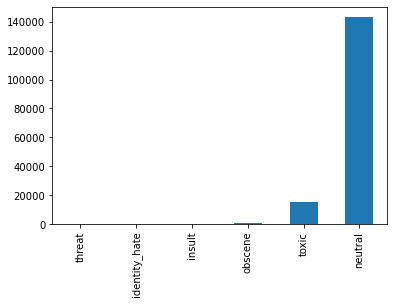

In [9]:
tweets.label.value_counts().sort_values().plot(kind = 'bar')

In [10]:
copy = tweets[tweets["label"] == 'neutral']
tweets = tweets[tweets["label"] != 'neutral']
tweets = tweets.append(copy[:tweets.toxic.shape[0]], ignore_index=True)

### Removed the excess neutral comments and now toxic and neutral are balanced



<AxesSubplot:>

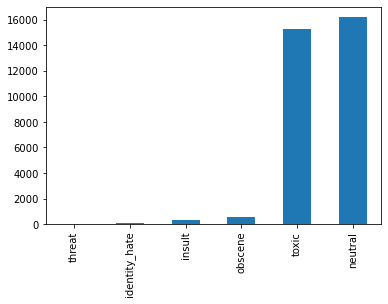

In [11]:
tweets.label.value_counts().sort_values().plot(kind = 'bar')

### Building the model with above data causes bias in the model so dropping the classes which does not have enough data

In [12]:
cleaned_data = tweets[["comment_text", "label"]]
cleaned_data = cleaned_data[(cleaned_data['label'] == "neutral") | (cleaned_data['label'] == "toxic") ]
cleaned_data

,comment_text,label
0,cocksucker piss around work,toxic
1,hey it talk it exclusive group talibans who go...,toxic
2,bye look come think comming back tosser,toxic
3,gay archangel white tiger meow greetingshh uh ...,toxic
4,fuck filthy mother ass dry,toxic
...,...,...
32445,template infobox former monarchy hi thumperwar...,neutral
32446,orphaned non free image image battmap gif than...,neutral
32447,height really good idea include height individ...,neutral
32448,dumb question non doctor wikipedian trying hel...,neutral


<AxesSubplot:>

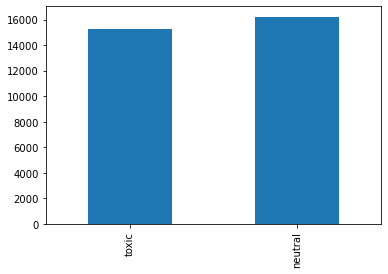

In [13]:
cleaned_data.label.value_counts().sort_values().plot(kind = 'bar')

### Word cloud building for Neutral/Polite class

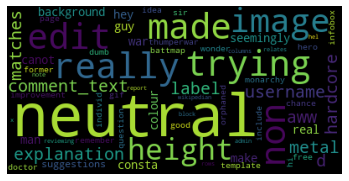

In [14]:
from wordcloud import WordCloud

import matplotlib.pyplot as plt



wordcloud = WordCloud().generate(str(cleaned_data[(cleaned_data['label'] == "neutral")]))

plt.figure()
plt.imshow(wordcloud)

plt.axis("off")

plt.show()

### Word cloud building for Toxic/Hateful class

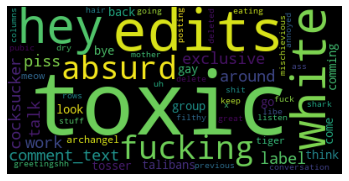

In [15]:
wordcloud = WordCloud().generate(str(cleaned_data[(cleaned_data['label'] == "toxic")]))


plt.imshow(wordcloud)

plt.axis("off")

plt.show()

### Word cloud building for both the classes

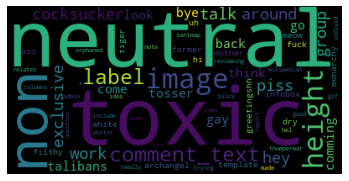

In [16]:
wordcloud = WordCloud().generate(str(cleaned_data))


plt.imshow(wordcloud)

plt.axis("off")

plt.show()

In [17]:
!pip install matplotlib-venn

from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
%matplotlib inline

  Using cached matplotlib-venn-0.11.7.tar.gz (29 kB)
  Created wheel for matplotlib-venn: filename=matplotlib_venn-0.11.7-py3-none-any.whl size=32154 sha256=41a9d962bb85d5608f8bcd359c2a95f4916682c32c8a76a5553f21fb6e4b53b6
  Stored in directory: c:\users\ashwi\appdata\local\pip\cache\wheels\32\41\5f\d0f29cd092d042d8e8a87d7bbe42193166aa555ff38b377343
Successfully built matplotlib-venn


In [19]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(cleaned_data[(cleaned_data['label'] == "toxic")]["comment_text"])
toxic_words = vectorizer.get_feature_names_out()

AttributeError: 'CountVectorizer' object has no attribute 'get_feature_names_out'

In [ ]:
Y = vectorizer.fit_transform(cleaned_data[(cleaned_data['label'] == "neutral")]["comment_text"])
neutral_words = vectorizer.get_feature_names_out()

In [ ]:
Z = vectorizer.fit_transform(cleaned_data["comment_text"])
full_words = vectorizer.get_feature_names_out()

In [ ]:
def intersection(list_a, list_b):
    return [ e for e in list_a if e in list_b ]

In [ ]:
common_words = intersection(toxic_words, neutral_words) #, assume_unique=False, return_indices=False)

In [ ]:
len(common_words)

### Venn Diagram to show the available number of words on both the classes and their common number of words

In [ ]:
venn2(subsets = (toxic_words.shape[0], neutral_words.shape[0], len(common_words)), set_labels = ('Hateful', 'Polite'))


### Tokenize the sentence into seperate words

In [ ]:
tokenizer = Tokenizer(num_words=100000)
tokenizer.fit_on_texts(cleaned_data["comment_text"])
word_index = tokenizer.word_index

### Load Glove Word embedding matrix

In [ ]:
path_to_glove_file = os.path.join("glove.twitter.27B/glove.twitter.27B.100d.txt")

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

In [ ]:
num_tokens = len(word_index) + 2
embedding_dim = 100
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

In [ ]:
MAX_SEQUENCE_LENGTH = 1000
filters=32
kernel_size= 32
lstm_units = 100


In [ ]:
embedding_matrix.shape

## Build the Model

### Embedding Layer with Glove data 100 dimensions and input length of 1000
### SpatialDropout1D Layer to prevent overfitting
### Conv1D considering sentence a matrix and extrating import features with 3s as filter and 32 as kernel size
### LeakyReLU as activation for next layer
### MaxPooling1D to compress the conv1d layer data
### bidirectional LSTM with 100 units


In [ ]:
inputs = keras.Input(shape=(sequence_length, num_features))
x = layers.LSTM(32, recurrent_dropout=0.2, unroll=True)(inputs)

In [ ]:
model = Sequential()
# model.add(Input(25960, 1000))
model.add(Embedding(input_dim=embedding_matrix.shape[0], output_dim=embedding_matrix.shape[1], weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False))
# model.add(Embedding( num_tokens,
#     embedding_dim,
#     embeddings_initializer=keras.initializers.Constant(embedding_matrix),
#     trainable=False))
model.add(SpatialDropout1D(0.5))
model.add(Conv1D(filters, kernel_size=kernel_size,kernel_regularizer=regularizers.l2(0.00001), padding='same'))
model.add(LeakyReLU(alpha=0.2))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(lstm_units,dropout=0.5, recurrent_dropout=0.5,return_sequences=True)))
model.add(SpatialDropout1D(0.5))
model.add(Conv1D(filters, kernel_size=kernel_size,kernel_regularizer=regularizers.l2(0.00001), padding='same'))
model.add(LeakyReLU(alpha=0.2))
model.add(MaxPooling1D(pool_size=2))
# model.add(Bidirectional(LSTM(lstm_units,dropout=0.5, recurrent_dropout=0.5,return_sequences=True)))
# model.add(SpatialDropout1D(0.5))
# model.add(Conv1D(filters, kernel_size=kernel_size,kernel_regularizer=regularizers.l2(0.00001), padding='same'))
# model.add(LeakyReLU(alpha=0.2))
# model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(lstm_units,dropout=0.5, recurrent_dropout=0.5)))
model.add(Dense(2,activation='softmax'))
model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['categorical_accuracy'])

Get unique classes

In [ ]:
classes = np.unique(cleaned_data["label"])
classes

Split the dataset into 80% train and 20% test data

In [ ]:
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
# from keras.utils import np_utils
from keras.preprocessing.sequence import pad_sequences
import os
from tensorflow.keras.callbacks import TensorBoard



encoder = LabelEncoder()
encoder.fit(cleaned_data["label"])
y_data = encoder.transform(cleaned_data["label"])

categorical_labels = to_categorical(y_data,num_classes=len(classes))
X_train, X_test, Y_train, Y_test = train_test_split(cleaned_data["comment_text"], categorical_labels, test_size=0.2)

In [ ]:
np.unique(cleaned_data["label"])

Pad the input to 1000 as uniform length of input size is required for training

In [ ]:
pad_X_train = pad_sequences(
   tokenizer.texts_to_sequences(X_train), maxlen = MAX_SEQUENCE_LENGTH
 )
pad_X_test =  pad_sequences(
     tokenizer.texts_to_sequences(X_test), maxlen = MAX_SEQUENCE_LENGTH
   )

## Start training the model

In [ ]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

model.fit(pad_X_train, Y_train, epochs=200, callbacks=[tb_callback])


# Testing the model

Accuracy of the test dataset

In [ ]:
from keras.preprocessing.sequence import pad_sequences
accr = model.evaluate(pad_sequences(tokenizer.texts_to_sequences(X_test)),Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Build the confusion matrix

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score
yhat = model.predict(pad_sequences(tokenizer.texts_to_sequences(X_test)))
ytrue = np.argmax(Y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()
cf = multilabel_confusion_matrix(ytrue, yhat)

# Plot the confusion matrix

Confusion Matrix for the Polite class

In [ ]:
import seaborn as sns;
group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf[0].flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf[0].flatten()/np.sum(cf[0])]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cf[0]/np.sum(cf[0]), annot=labels, fmt='')
ax.set_title('Confusion Matrix for \n Polite Speech Detection')
plt.xlabel('Predicted')

plt.ylabel('Actual')

plt.grid(False)

Confusion Matrix for the Hateful class

In [ ]:

group_counts = ["{0:0.0f}".format(value) for value in
                cf[1].flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf[1].flatten()/np.sum(cf[1])]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)


ax = sns.heatmap(cf[1]/np.sum(cf[1]), annot=labels, fmt='')
ax.set_title('Confusion Matrix for \n Hateful Speech Detection')
plt.xlabel('Predicted')

plt.ylabel('Actual')

plt.grid(False)

Accuracy score for the test data

In [ ]:
accuracy_score(ytrue, yhat)

# Save the Model to be used in the application

In [ ]:
model.save('NLP4.h5')

# Pickel the tokenizer for input conversion in the model

In [ ]:
import pickle
with open("tokenizer4.pkl", 'wb') as f:
    pickle.dump(tokenizer, f)